# Getting Started with Slurm
Slurm is a cluster management and job scheduling system for linux clusters. This tutorial covers the basic job submission, monitoring, and accounting operation. 

## Submit and Run your first job
Just like countless other tutorial about anything tech, this guide started with a helloworld as your first job submitted to Slurm. This job prints the message, then print hostname, kernel, date, and sleep indefinitely so that the job won't exist until being killed, or reaching its timelimit.

In [ ]:
cat ./helloworld.sh

In [ ]:
sbatch ./helloworld.sh

### Keep an eye on it
Now the job has be submitted to Slurm. We can take a look a job, partition and node status. 

#### Job Information
`squeue` command show the job status is the queue. Most common status are "PENDING", and "RUNNING". When the job is running, the list of nodes allocated to the job will be shown. When the job is pending, it shows the reason why the job is not yet started. eg. "Resource" means the job is next in the queue, but resource requested is not available yet; "Priority" means the job has lower priority than some other job in the queue, and not being consider for execution yet. 

In [ ]:
squeue

User `-la` options to show more information. 

In [ ]:
squeue -la 

You could also monitor it in the [Jupyterhub Slurm Extension](https://jupyterlab-slurm.readthedocs.io/en/latest/index.html).

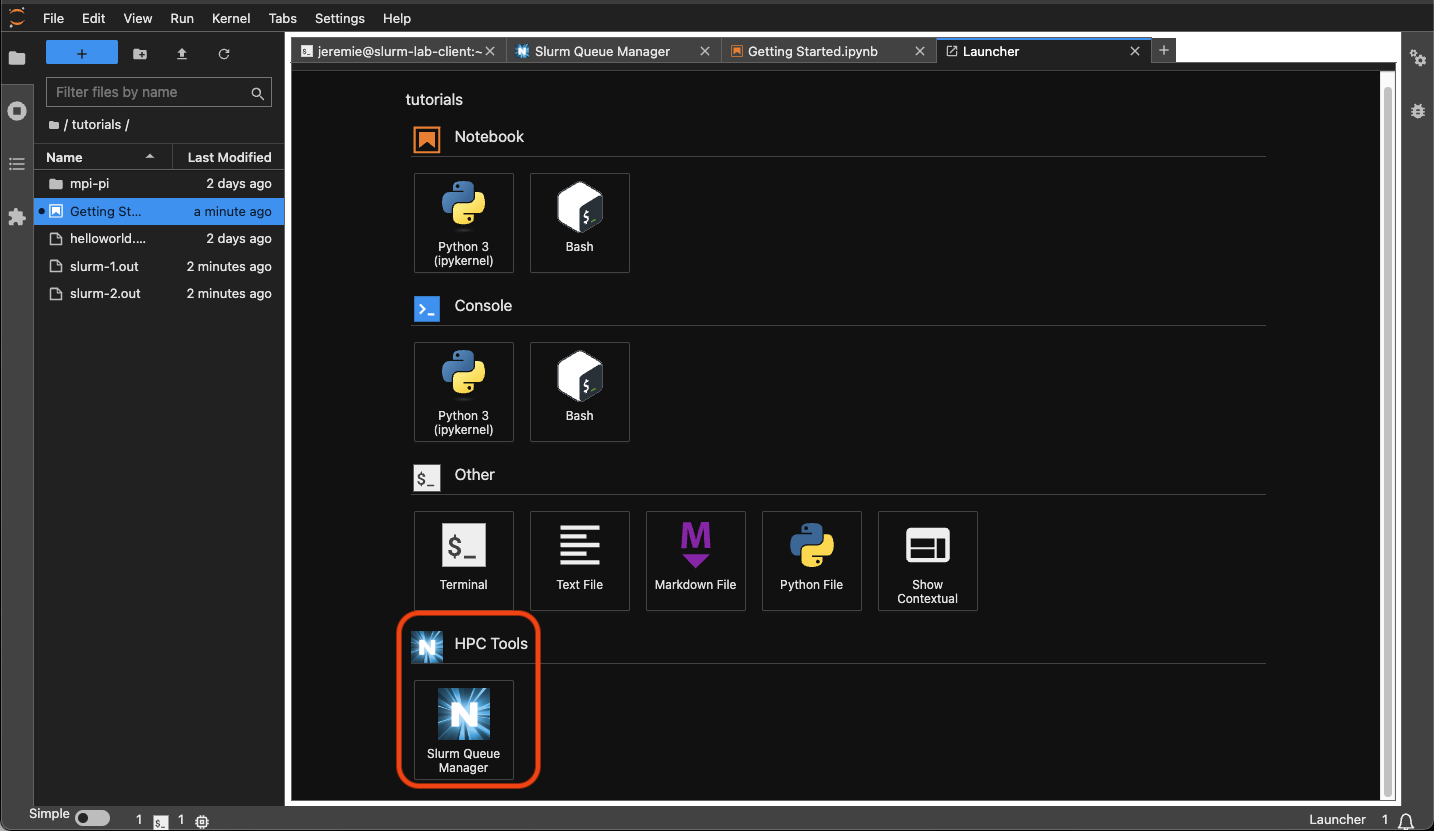

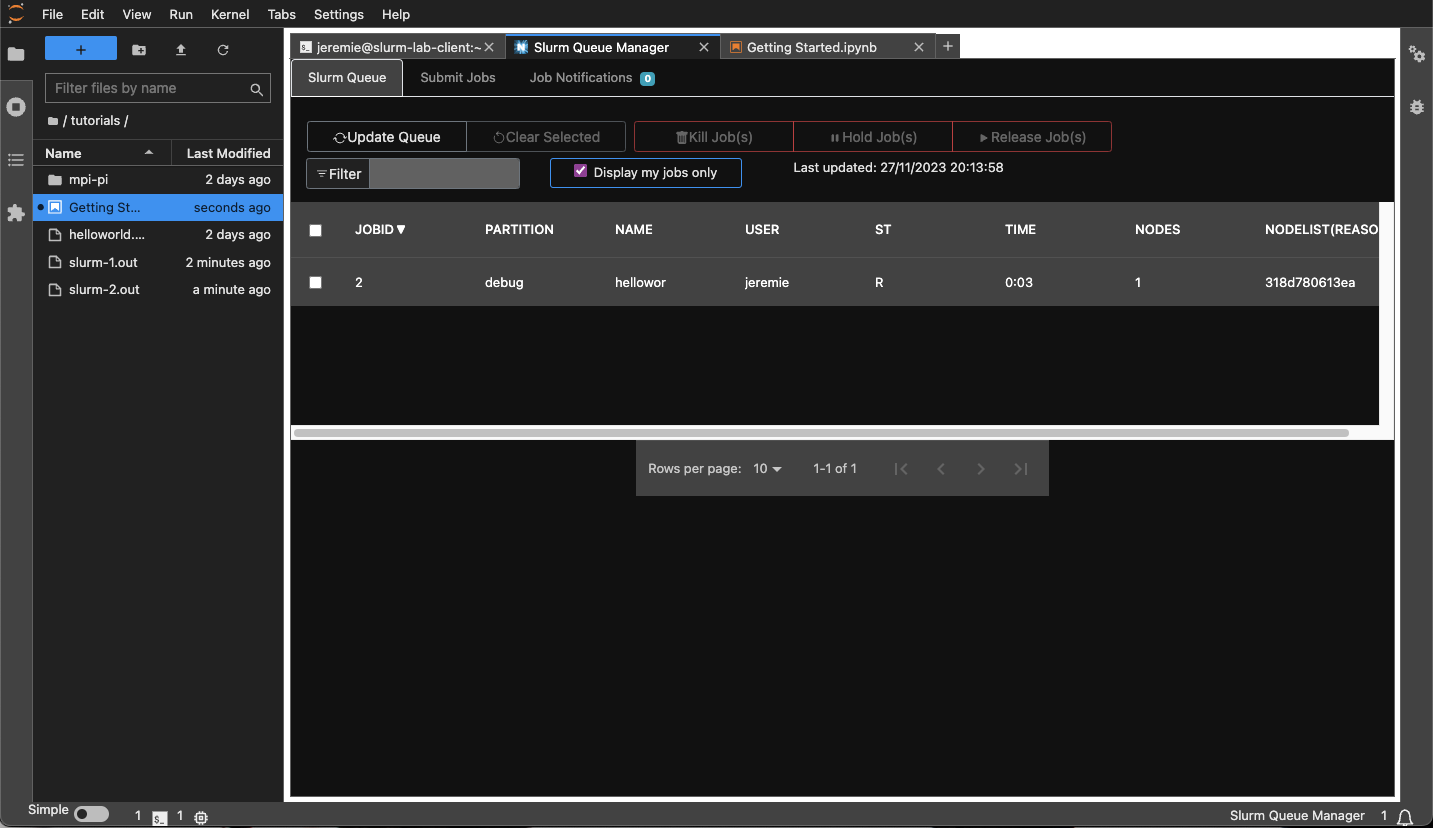

Slurm accounting service is configured in this lab cluster, so the `sacct` command could also show you information about currently runnning job and history of finished jobs. 

In [ ]:
sacct

#### Partition and node information
We can get partition and node information using the `sinfo` command. For partition state and info:

In [ ]:
sinfo -l

Status and info of individual node, use options "--N" and "--long". You can get information like no. of cpus, totol memory, states, and which partition does a node belongs to.

In [ ]:
sinfo --N --long

These are some of the common node status:
- idle: the node is free, not running any job at the moment.
- allocated: all resource in the node has been allocated to job.
- mixed: job is currently running on the node, but resource is still available for more jobs
- draining/drained: the node is configured not to take new job, currently running job will keep going until finish. 
- "\*": if you see a "*" in node state, that means slurm master had lost communication to that compute node. then state showing is the last known state of that node. 

For partition there are 4 possible states:  

|   | Accepting job | Rejecting job |
|---|---------------|---------------|
| Dispatching job | UP   | DRAIN    |
| Holding job     | DOWN | INACTIVE | 

### Cancel the job
To cancel a running or pending job, use the `scancel <jobid>` command. 

In [ ]:
scancel 1

### Job Output
By default, the stdout and stderr of the job will be printed to an output file under the directory you submit the job, named slurm-\<jobid\>.out.
If your submission directory is a shared fs then you could look at the job output soon after the job had started. However if it is not a shared fs, since the file is created locally on the execution host, you will need to login to that host to read the job output.

In [ ]:
cat slurm-1.out

## Job Configuration
The hello world example requires only one core, so the default 1 core allocation is enough. For jobs that require more resource, of course you need to request more resource (eg. cpu, memory, gpu, burst buffer). You can put a limit to the job as well, eg. if you know your job won't take more than an hour, specificing a time limit could speed up scheduling, and if anything goes wrong, it won't hang forever. You could also define begin time, deadline, and job dependency to construct a complex workflow of multiple jobs.

##### Frequently used job config options  

| Option | Explaination |
|--------|--------------|
| [`--partition <partition>`](/doc/sbatch.html#OPT_partition) | Partition/Queue the job is submitted to. |
| [`--ntasks <N>`](/doc/sbatch.html#OPT_ntasks)  | Total no. of processes, each process occupy at least 1 core |
| [`--mem <size>[unit]`](/doc/sbatch.html#OPT_mem) | Size of memory required **per node**. `--mem=0` is a special case to request **ALL** memory available on the allocated node.|
| [`--nodes <N>`](/doc/sbatch.html#OPT_nodes)   | no. of nodes required for the job |
| [`--ntasks-per-node <N>`](/doc/sbatch.html#OPT_ntasks-per-node) | no. of task required per node, normally use with `--nodes <N>` |
| [`--cpus-per-task <N>`](/doc/sbatch.html#OPT_cpus-per-task)   | no. of CPUs required for each process, useful when running multithreading jobs |
| [`--export=var1=val1,var2=val2`](/doc/sbatch.html#OPT_export) | define custom environment variable for the job. Help make the job script more generic |
| [`--time <time>`](/doc/sbatch.html#OPT_time) | set run time limit to the job |
| [`--begin <time>`](/doc/sbatch.html#OPT_begin) | Set the earliest time the job can start |
| [`--deadline <time>`](/doc/sbatch.html#OPT_deadline) | Job deadline, cancel the job if cannot be scheduled to finish before this time |
| [`--dependency <list of conditions>`](/doc/sbatch.html#OPT_dependency) | Define dependency to other jobs |
| [`--output <filename pattern>`](/doc/sbatch.html#OPT_output) | Name the output file something other than `slurm-<jobid>.out` |


### Compute Resource & Environment Variables

#### Define in Job script
At the top of the job script, you could define some of the resource requirement / options. For example 

In [ ]:
cat ./endless-checksum-mpi.sh

In [ ]:
sbatch ./endless-checksum-mpi.sh

#### sbatch command line arguement
You can also use these options as command line option of sbatch, and they have high priority than options defined in the script. For example if instead of getting 4 core from any nodes available, I want 1 core from each 4 nodes, and get all memory. i could use the same script aub submit with options.

In [ ]:
sbatch --nodes=4 --ntasks-per-node=1 --mem=0 ./endless-checksum-mpi.sh

#### Environment variable and redistribute resource
Slurm provides some environment variables that describe the job configuration. The are useful when you try to develop more generic job scripts.  

| Variable | Description |
|----------|-------------|
| `$SLURM_JOBID`, `$SLURM_JOB_ID` | JobID of the job |
| `$SLURM_JOB_NODELIST `, `$SLURM_NODELIST` | Hostname of allocated node, use `scontrol show hostname ${SLURM_NODELIST}` to expand the list |
|`$SLURM_NTASKS`, `$SLURM_NTASKS_PER_NODE`, `$SLURM_NNODES`, `$SLURM_CPUS_PER_TASK`| $ntasks = cpus\_per\_task \times ntasks\_per\_node \times nnode $, and `$SLURM_CPUS_PER_TASK` is commonly used as `OMP_NUM_THREADS` when running openmp jobs. |


You also pass your own environment variable to the job using the `--export` option. 


In [ ]:
cat ./endless-checksum-srun.sh

In this `endless-checksum-srun.sh` example job script, we will try to print some of the variable set by slurm, and one custum variable passed from command line. We will also use the srun command withing the script to allocate a slice of the resource to run different commands. This is useful if you want to run a buch of scripts in one job script, and don't care if the allocated cores are on few different nodes. 

In [ ]:
sbatch --export=NAME=$(whoami) --nodes=4 --ntasks-per-node=2 ./endless-checksum-srun.sh

In [ ]:
sbatch --ntasks=5 ./endless-checksum-srun.sh

### Time Restriction

If you have a rough idea of how much time is needed for the job, setting a time limit could help your job start ealier as the scheduler might allow your job to cut-in-line or backfill if another job finished earlier and resource are sufficient for long enough time to cater your job first.

Setting begin time is useful if you want to submit your job now but don't want it to start until after a certain time. 

Setting a deadline is useful if the job become meaningless after a certain. for example if you try to run a weather prediction of the next, the job is become meaningless after midnight. 

You can set time limit, begin time, deadline to a job. Let's use the endless-check-mpi.sh as an example again. 

In [ ]:
# limit job to run for no more than 10 min
sbatch --time 00:10:00 --ntasks=8 ./endless-checksum-mpi.sh
# job to start after next midnight
sbatch --time 00:10:00 --begin 00:00:00 --ntasks=4 ./endless-checksum-mpi.sh
# job to start after 1 min, deadline before 10 min, time limit of 5 min
sbatch --time 00:05:00 --begin now+1minute --deadline now+10minute --ntasks=4 ./endless-checksum-mpi.sh

If you run this cell to submit all 3 jobs together. the first job start running as it has the high priority. The third job stays in pending state for a minute, then the reason of pending turns into "Resourse". Now if you cancel the first job, resource will be availabe for the third to start. However, the secondary will stay in pending state with reason "BeginTime", and slurm will only start schedule this job after midnight.

### Dependency
You can also divide your workflow into smaller jobs/stages, and link them using `--dependency`. For example you could split your jobs into smaller job and one big main job.  
![job-dependency](./job-dependency/job-dependency.png)  
Typical relation between jobs are after, afterok, afternotok, afterany:
* (afterok)    pre-process is a smaller job that run priori to the main job, eg. data sanitization, or even download dataset. It must finish normally before the main process could start
* (afterok)    post-process depends on main process to complete successfully
* (after)      co-process could be some output monitoring or profilling process, that can only start after the main process had started
* (afterany)   clean up is a job to clean up intermediate output, it should run regards less of the exit status of the main process
* (afternotok) if main process has any error, run error handle job. 

In [ ]:
# successful workflow
(
    set -x
    cd job-dependency
    rm -f *.out
    PREPROCESS_JOB=$( sbatch --parsable --output=pre.out ./pre-process.sh)
    MAIN_JOB=$(       sbatch --parsable --output=main.out  --dependency=afterok:${PREPROCESS_JOB} --time 00:02:00  ./main-process.sh)
    COPROCESS_JOB=$(  sbatch --parsable --output=co.out    --dependency=after:${MAIN_JOB} ./co-process.sh)
    CLEANUP_JOB=$(    sbatch --parsable --output=clean.out --dependency=afterany:${MAIN_JOB} ./clean-up.sh)
    POSTPROCESS_JOB=$(sbatch --parsable --output=post.out  --dependency=afterok:${MAIN_JOB} ./post-process.sh)
    ERROR_JOB=$(      sbatch --parsable --output=error.out --dependency=afternotok:${MAIN_JOB} ./error-handle.sh)
    set +x
)

In [ ]:
# fail workflow: intensionally setting main job to be timed out
(
    set -x
    cd job-dependency
    rm -f *.out
    PREPROCESS_JOB=$( sbatch --parsable --output=pre.out ./pre-process.sh)
    MAIN_JOB=$(       sbatch --parsable --output=main.out  --dependency=afterok:${PREPROCESS_JOB} --time 00:01:00  ./main-process.sh)
    COPROCESS_JOB=$(  sbatch --parsable --output=co.out    --dependency=after:${MAIN_JOB} ./co-process.sh)
    CLEANUP_JOB=$(    sbatch --parsable --output=clean.out --dependency=afterany:${MAIN_JOB} ./clean-up.sh)
    POSTPROCESS_JOB=$(sbatch --parsable --output=post.out  --dependency=afterok:${MAIN_JOB} ./post-process.sh)
    ERROR_JOB=$(      sbatch --parsable --output=error.out --dependency=afternotok:${MAIN_JOB} ./error-handle.sh)
    set +x
)

In either one of the workflow, you see there is a job left in pending state with reason "DependencyNeverSatisfied", and you will need to cancel that job manually. If you want slurm to cancel such a job automatically use option [`--kill-on-invalid-dep=yes`](/doc/sbatch.html#OPT_kill-on-invalid-dep)

## Interactive Job
So far all the jobs need a job script, and you have no interaction with the compute resource. If you need to run a interactive program, or need to develop the job script interactive, you can start an interactive job in slurm. 

```
srun [opts] --pty bash
```
most sbatch options can be used here

Remark: you need to try this command in the terminal. interactive prompt is not supported in notebook 